[I 2025-04-21 01:17:43,018] A new study created in memory with name: no-name-f2db22f5-72e4-4532-9172-b61a035683f3
[I 2025-04-21 01:18:16,726] Trial 0 finished with value: 18490.714929057413 and parameters: {'lr': 0.0004273659976539842, 'lr_value': 0.0002260008030135757, 'gamma': 0.9430949993425266, 'eps_clip': 0.1571472061938486, 'trend_reward_coef': 0.02234524111693494, 'sentiment_reward_coef': 0.01064137127769583, 'episode_length': 344}. Best is trial 0 with value: 18490.714929057413.
[I 2025-04-21 01:18:52,479] Trial 1 finished with value: 25519.998396247596 and parameters: {'lr': 2.1542351506080138e-05, 'lr_value': 0.0016956776049638523, 'gamma': 0.9821512707752985, 'eps_clip': 0.16056442356836953, 'trend_reward_coef': 0.08584372248076472, 'sentiment_reward_coef': 0.015679749327170398, 'episode_length': 394}. Best is trial 1 with value: 25519.998396247596.
[I 2025-04-21 01:19:05,103] Trial 2 finished with value: 18614.232299522035 and parameters: {'lr': 0.004428009186300271, 'lr_va

Best hyperparameters: {'lr': 0.00046732797764326226, 'lr_value': 0.00022192870026771044, 'gamma': 0.9038702302176629, 'eps_clip': 0.2449968231409991, 'trend_reward_coef': 0.044391238078361046, 'sentiment_reward_coef': 0.01553354729142637, 'episode_length': 486}
Best value (final net worth): 48291.781432057585
Episode 1 | Total Reward: 1.87 | Net Worth: 29191.20 | Action Mean: -0.19, Std: 0.64
Episode 2 | Total Reward: 0.96 | Net Worth: 31893.60 | Action Mean: -0.03, Std: 0.70
Episode 3 | Total Reward: 2.19 | Net Worth: 37036.81 | Action Mean: -0.15, Std: 0.65
Episode 4 | Total Reward: 2.18 | Net Worth: 36471.65 | Action Mean: -0.15, Std: 0.67
Episode 5 | Total Reward: 0.90 | Net Worth: 25425.00 | Action Mean: -0.09, Std: 0.65
Episode 6 | Total Reward: 2.55 | Net Worth: 30440.43 | Action Mean: -0.07, Std: 0.67
Episode 7 | Total Reward: 1.46 | Net Worth: 21544.48 | Action Mean: -0.16, Std: 0.65
Episode 8 | Total Reward: 1.72 | Net Worth: 24882.03 | Action Mean: -0.12, Std: 0.66
Episode 9

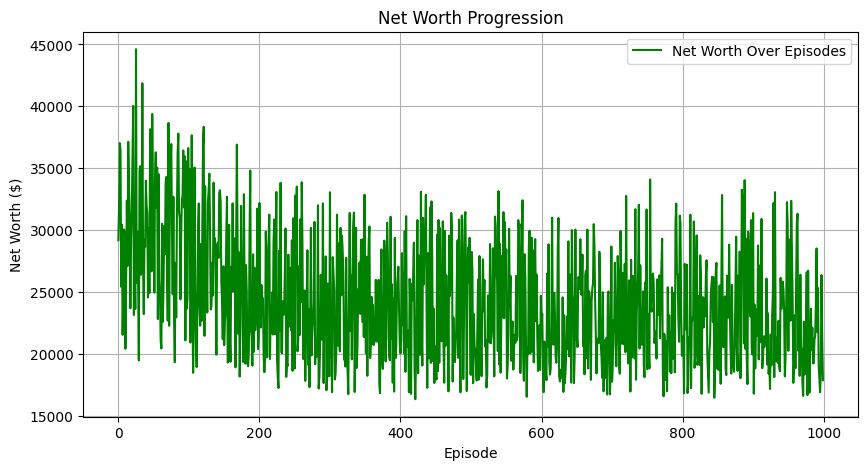

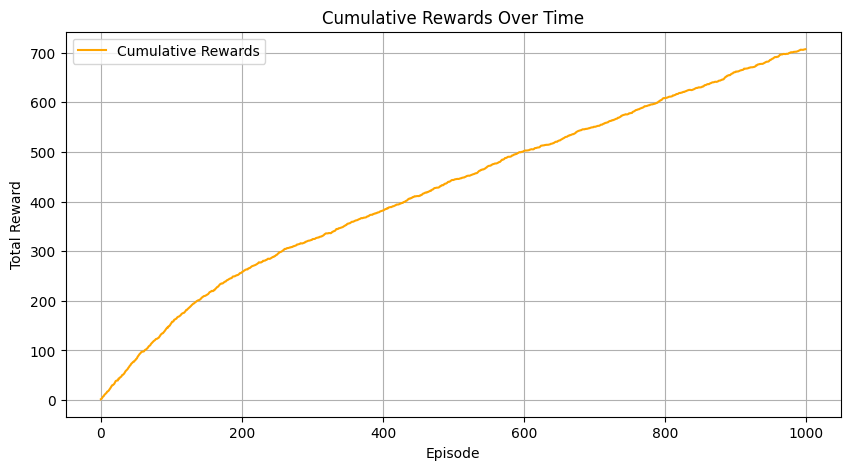

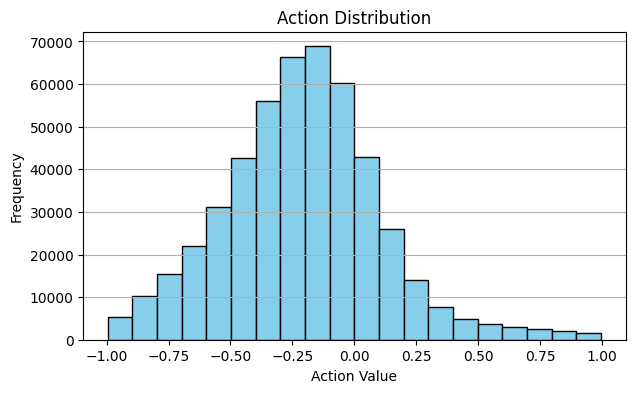

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import gym
from gym import spaces
import optuna

# Policy Network
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, action_dim)
        )
        self.log_std = nn.Parameter(torch.zeros(action_dim) + 0.15)

    def forward(self, state):
        mean = self.fc(state)
        std = torch.exp(self.log_std.clamp(min=-2, max=0.6))
        return mean, std

class ValueNetwork(nn.Module):
    def __init__(self, state_dim):
        super(ValueNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, state):
        return self.fc(state)

# Stock Trading Environment
class StockTradingEnv(gym.Env):
    def __init__(self, data, initial_capital=10000, stop_loss_pct=0.02, episode_length=300, trend_reward_coef=0.02, sentiment_reward_coef=0.01):
        super(StockTradingEnv, self).__init__()
        self.data = data.reset_index(drop=True)
        self.initial_capital = initial_capital
        self.stop_loss_pct = stop_loss_pct
        self.episode_length = episode_length
        self.trend_reward_coef = trend_reward_coef
        self.sentiment_reward_coef = sentiment_reward_coef
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(8,), dtype=np.float32)
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.stop_loss_count = 0
        self.reward_history = []
        self.peak_net_worth = initial_capital

    def reset(self):
        self.current_step = np.random.randint(0, len(self.data) - self.episode_length)
        self.start_step = self.current_step
        self.net_worth = self.initial_capital
        self.position = 0.0
        self.prev_action = 0.0
        self.prev_total_assets = self.initial_capital
        self.stop_loss_count = 0
        self.reward_history = []
        self.peak_net_worth = self.initial_capital
        return self._get_observation()

    def _get_observation(self):
        start = max(0, self.current_step - 4)
        recent_data = self.data.iloc[start:self.current_step + 1]
        price_changes = recent_data['Average_Price_Change'].values
        if len(price_changes) < 5:
            price_changes = np.pad(price_changes, (5 - len(price_changes), 0), mode='constant')
        scaled_prices = price_changes / 0.15

        row = self.data.iloc[self.current_step]
        volatility_map = {'Low': 0, 'Medium': 1, 'High': 2}
        trend_map = {'Downtrend': -1, 'Stable': 0, 'Uptrend': 1}

        # Scale Sentiment_Score to [-1, 1]
        sentiment_scaled = np.clip(row['Sentiment_Score'], -2, 2) / 2

        return np.concatenate([
            scaled_prices,
            [volatility_map.get(row['Volatility_Level'], 1) / 2.0,
             sentiment_scaled,
             trend_map.get(row['Trend_Classification'], 0)]
        ], dtype=np.float32)

    def step(self, action):
        action = float(np.clip(action, -1, 1))
        row = self.data.iloc[self.current_step]
        current_price = row['End_Price']
        trend = {'Downtrend': -1, 'Stable': 0, 'Uptrend': 1}.get(row['Trend_Classification'], 0)
        delta_position = action - self.position

        transaction_cost = abs(delta_position) * current_price * 0.002
        if delta_position > 0:
            buy_cost = delta_position * current_price + transaction_cost
            if self.net_worth >= buy_cost:
                self.net_worth -= buy_cost
                self.position += delta_position
        elif delta_position < 0:
            sell_gain = -delta_position * current_price - transaction_cost
            self.net_worth += sell_gain
            self.position += delta_position

        self.position = np.clip(self.position, 0, 1)
        unrealized_value = self.position * current_price
        total_assets = self.net_worth + unrealized_value
        self.peak_net_worth = max(self.peak_net_worth, total_assets)

        # Smoothed and profit-locking reward function
        self.reward_history.append((total_assets - self.prev_total_assets) / self.initial_capital)
        if len(self.reward_history) > 10:
            smoothed_profit = np.mean(self.reward_history[-10:])
        else:
            smoothed_profit = np.mean(self.reward_history)
        volatility_map = {'Low': 0, 'Medium': 0.0005, 'High': 0.001}
        reward = smoothed_profit
        reward += self.trend_reward_coef * (action * trend)
        reward += self.sentiment_reward_coef * (action * row['Sentiment_Score'])
        reward -= 0.0005 * abs(delta_position)
        reward -= 0.00025 * action**2
        reward -= volatility_map.get(row['Volatility_Level'], 0.0005)
        if delta_position < 0 and total_assets < self.prev_total_assets:
            reward += 0.002 * abs(delta_position)
        if total_assets > self.peak_net_worth * 0.95 and delta_position < 0:
            reward += 0.003 * abs(delta_position)

        self.prev_total_assets = total_assets
        done = False

        if total_assets <= self.initial_capital * (1 - self.stop_loss_pct):
            done = True
            self.stop_loss_count += 1
            print(f"Stop-loss triggered at Episode {episode}, Step {self.current_step}, Net Worth: {total_assets:.2f}")

        self.prev_action = action
        self.current_step += 1
        if self.current_step >= len(self.data) - 1 or self.current_step - self.start_step >= self.episode_length:
            done = True

        next_state = self._get_observation() if not done else np.zeros_like(self._get_observation())
        return next_state, reward, done, {'net_worth': self.net_worth, 'position': self.position}

    def render(self):
        print(f"Step: {self.current_step}, Net Worth: {self.net_worth:.2f}, Position: {self.position:.2f}")

# PPO Agent
class PPOAgent:
    def __init__(self, state_dim, action_dim, lr, lr_value, gamma, eps_clip):
        self.policy = PolicyNetwork(state_dim, action_dim)
        self.value = ValueNetwork(state_dim)
        self.policy_old = PolicyNetwork(state_dim, action_dim)
        self.policy_old.load_state_dict(self.policy.state_dict())

        self.policy_optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.value_optimizer = optim.Adam(self.value.parameters(), lr=lr_value)
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.mse_loss = nn.MSELoss()
        self.lr_scheduler = optim.lr_scheduler.StepLR(self.policy_optimizer, step_size=100, gamma=0.97)

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        mean, std = self.policy_old(state)
        dist = torch.distributions.Normal(mean, std)
        raw_action = dist.rsample()
        action = torch.tanh(raw_action.clamp(-3, 3))
        log_prob = dist.log_prob(raw_action).sum(dim=-1)
        return action.squeeze().detach().numpy(), log_prob.squeeze()

    def update(self, memory):
        states = torch.FloatTensor(np.array(memory['states']))
        actions = torch.FloatTensor(np.array(memory['actions']))
        old_log_probs = torch.stack(memory['log_probs']).detach()
        rewards = memory['rewards']

        returns = []
        discounted_sum = 0
        for reward in reversed(rewards):
            discounted_sum = reward + self.gamma * discounted_sum
            returns.insert(0, discounted_sum)
        returns = torch.FloatTensor(returns)

        values = self.value(states).squeeze().detach()
        advantages = returns - values
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        for _ in range(10):
            mean, std = self.policy(states)
            mean = torch.clamp(mean, -0.375, 0.375)
            dist = torch.distributions.Normal(mean, std)
            new_log_probs = dist.log_prob(actions).sum(dim=-1)
            entropy = dist.entropy().sum(dim=-1).mean()

            values = self.value(states).squeeze()
            ratio = torch.exp(new_log_probs - old_log_probs)
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - self.eps_clip, 1 + self.eps_clip) * advantages

            policy_loss = -torch.min(surr1, surr2).mean()
            value_loss = self.mse_loss(values, returns)

            self.policy_optimizer.zero_grad()
            self.value_optimizer.zero_grad()
            total_loss = policy_loss + 0.5 * value_loss - 0.2 * entropy
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
            self.policy_optimizer.step()
            self.value_optimizer.step()

        self.policy.log_std.data = torch.clamp(self.policy.log_std.data - 0.011, min=-2, max=0.6)
        self.policy_old.load_state_dict(self.policy.state_dict())
        self.lr_scheduler.step()

def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    if len(returns) < 2:
        return 0.0
    excess_returns = np.array(returns) - risk_free_rate
    mean_return = np.mean(excess_returns)
    std_return = np.std(excess_returns)
    return mean_return / (std_return + 1e-8) if std_return > 0 else 0.0

def plot_net_worth(net_worths):
    plt.figure(figsize=(10, 5))
    plt.plot(net_worths, label='Net Worth Over Episodes', color='green')
    plt.xlabel('Episode')
    plt.ylabel('Net Worth ($)')
    plt.title('Net Worth Progression')
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_cumulative_rewards(rewards):
    cumulative = np.cumsum(rewards)
    plt.figure(figsize=(10, 5))
    plt.plot(cumulative, label='Cumulative Rewards', color='orange')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Cumulative Rewards Over Time')
    plt.grid()
    plt.legend()
    plt.show()

def plot_action_distribution(actions):
    plt.figure(figsize=(7, 4))
    plt.hist(actions, bins=20, color='skyblue', edgecolor='black')
    plt.title('Action Distribution')
    plt.xlabel('Action Value')
    plt.ylabel('Frequency')
    plt.grid(axis='y')
    plt.show()

def preprocess_data(data):
    data['Average_Price_Change'] = (
        data['Average_Price_Change'] - data['Average_Price_Change'].mean()
    ) / data['Average_Price_Change'].std()
    data['Sentiment_Score'] = (
        data['Sentiment_Score'] - data['Sentiment_Score'].mean()
    ) / data['Sentiment_Score'].std()
    return data

# Objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    lr_value = trial.suggest_float('lr_value', 1e-5, 1e-2, log=True)
    gamma = trial.suggest_float('gamma', 0.9, 0.99)
    eps_clip = trial.suggest_float('eps_clip', 0.1, 0.3)
    trend_reward_coef = trial.suggest_float('trend_reward_coef', 0.01, 0.1)
    sentiment_reward_coef = trial.suggest_float('sentiment_reward_coef', 0.01, 0.1)
    episode_length = trial.suggest_int('episode_length', 100, 500)

    # Load and preprocess data
    df = pd.read_csv("train_synthetic_stock_dataset2.csv")
    data = preprocess_data(df)
    env = StockTradingEnv(data, episode_length=episode_length, trend_reward_coef=trend_reward_coef, sentiment_reward_coef=sentiment_reward_coef)

    # Initialize agent
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    agent = PPOAgent(state_dim=state_dim, action_dim=action_dim, lr=lr, lr_value=lr_value, gamma=gamma, eps_clip=eps_clip)

    # Training loop
    memory = {'states': [], 'actions': [], 'log_probs': [], 'rewards': []}
    total_rewards = []
    net_worths = []
    episode_returns = []

    for episode in range(100):  # Reduced to 100 episodes for faster trials
        state = env.reset()
        done = False
        episode_reward = 0
        episode_net_worths = [env.net_worth]

        while not done:
            action, log_prob = agent.select_action(state)
            next_state, reward, done, info = env.step(action)

            memory['states'].append(state)
            memory['actions'].append(action)
            memory['log_probs'].append(log_prob)
            memory['rewards'].append(reward)
            state = next_state
            episode_reward += reward
            episode_net_worths.append(info['net_worth'])

        episode_return = (episode_net_worths[-1] - episode_net_worths[0]) / env.initial_capital
        episode_returns.append(episode_return)

        agent.update(memory)
        memory = {'states': [], 'actions': [], 'log_probs': [], 'rewards': []}
        total_rewards.append(episode_reward)
        net_worths.append(env.net_worth)

    # Objective is the final net worth
    final_net_worth = net_worths[-1]
    return final_net_worth

# Run Optuna study
if __name__ == "__main__":
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)  # Adjust n_trials as needed

    print("Best hyperparameters:", study.best_params)
    print("Best value (final net worth):", study.best_value)

    # Train with best params and save model
    best_params = study.best_params
    df = pd.read_csv("train_synthetic_stock_dataset2.csv")
    data = preprocess_data(df)
    env = StockTradingEnv(data, episode_length=best_params['episode_length'],
                         trend_reward_coef=best_params['trend_reward_coef'],
                         sentiment_reward_coef=best_params['sentiment_reward_coef'])

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    agent = PPOAgent(state_dim=state_dim, action_dim=action_dim, lr=best_params['lr'],
                     lr_value=best_params['lr_value'], gamma=best_params['gamma'],
                     eps_clip=best_params['eps_clip'])

    memory = {'states': [], 'actions': [], 'log_probs': [], 'rewards': []}
    total_rewards = []
    all_actions = []
    net_worths = []
    episode_returns = []

    for episode in range(1000):
        state = env.reset()
        done = False
        episode_reward = 0
        episode_net_worths = [env.net_worth]

        while not done:
            action, log_prob = agent.select_action(state)
            next_state, reward, done, info = env.step(action)

            memory['states'].append(state)
            memory['actions'].append(action)
            memory['log_probs'].append(log_prob)
            memory['rewards'].append(reward)
            all_actions.append(float(action))
            state = next_state
            episode_reward += reward
            episode_net_worths.append(info['net_worth'])

        episode_return = (episode_net_worths[-1] - episode_net_worths[0]) / env.initial_capital
        episode_returns.append(episode_return)

        agent.update(memory)
        memory = {'states': [], 'actions': [], 'log_probs': [], 'rewards': []}
        total_rewards.append(episode_reward)
        net_worths.append(env.net_worth)

        if (episode + 1) % 10 == 0:
            sharpe = calculate_sharpe_ratio(episode_returns[-100:])
            print(f"Episode {episode+1} | Total Reward: {episode_reward:.2f} | "
                  f"Net Worth: {env.net_worth:.2f} | "
                  f"Action Mean: {np.mean(all_actions[-100:]):.2f}, Std: {np.std(all_actions[-100:]):.2f} | "
                  f"Sharpe Ratio: {sharpe:.3f}")
        else:
            print(f"Episode {episode+1} | Total Reward: {episode_reward:.2f} | "
                  f"Net Worth: {env.net_worth:.2f} | "
                  f"Action Mean: {np.mean(all_actions[-100:]):.2f}, Std: {np.std(all_actions[-100:]):.2f}")

    torch.save(agent.policy.state_dict(), 'policy_weights.pth')
    torch.save(agent.value.state_dict(), 'value_weights.pth')

    plot_net_worth(net_worths)
    plot_cumulative_rewards(total_rewards)
    plot_action_distribution(all_actions)